In [1]:
# ============================================================
# Cell 1 – deterministic lightning simulator (seed=424242)
#           with per-station arrival‐window labels
# ============================================================
import numpy as np, math
from scipy.signal import butter, filtfilt

# ── User parameters ─────────────────────────────────────────
SEED         = 424242
duration_min = 5            # minutes
scenario     = 'far'     # 'near', 'medium', or 'far'

# ── Configuration ───────────────────────────────────────────
FS    = 109_375
BITS  = 14; VREF = 1.0

rng = np.random.default_rng(SEED)

stations = {
    'LON': {'lat':51.50, 'lon':-0.12},
    'LER': {'lat':60.15, 'lon':-1.13},
    'DUB': {'lat':53.35, 'lon':-6.26},
    'BER': {'lat':52.52, 'lon':13.40},
}
station_order = ['LON','LER','DUB','BER']

lat0 = np.mean([s['lat'] for s in stations.values()])
lon0 = np.mean([s['lon'] for s in stations.values()])
radius_km = {'near':50, 'medium':200, 'far':600}[scenario]

# ── Timing ──────────────────────────────────────────────────
pre_sec   = rng.uniform(5, 30)                 # quiet prelude
storm_sec = duration_min * 60
total_sec = pre_sec + storm_sec
N         = int(FS * total_sec)

# ── Haversine ──────────────────────────────────────────────
def hav(lat1,lon1,lat2,lon2):
    R = 6371.0
    φ1,φ2 = map(math.radians, (lat1, lat2))
    dφ    = math.radians(lat2 - lat1)
    dλ    = math.radians(lon2 - lon1)
    a     = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

# ── Generate flash & stroke times ──────────────────────────
events = []; t = pre_sec
while True:
    t += rng.lognormal(3.0, 1.0)
    if t >= total_sec: break
    # random flash location
    d = radius_km * math.sqrt(rng.random())
    θ = rng.uniform(0, 2*math.pi)
    lat = lat0 + (d/111.0)*math.cos(θ)
    lon = lon0 + (d/111.0)*math.sin(θ)/math.cos(math.radians(lat0))
    strokes = [t]
    for _ in range(rng.integers(1,4)-1):
        strokes.append(strokes[-1] + rng.uniform(0.01, 0.05))
    events.append({'stroke_times':strokes, 'lat':lat, 'lon':lon})

# ── Precompute bursts & per-station truth labels ───────────
wave_dur = 0.04
wave_len = int(wave_dur * FS)
W        = 1024
n_win    = N // W

station_truth = {nm: np.zeros(n_win, bool) for nm in station_order}
master_events = []
burst_list     = []
eid = 0

for ev in events:
    eid += 1
    rec = {'id':eid}
    for t0 in ev['stroke_times']:
        for nm in station_order:
            geo  = stations[nm]
            dist = hav(ev['lat'], ev['lon'], geo['lat'], geo['lon'])
            i0   = int((t0 + dist/300_000.0) * FS)
            if i0 >= N: continue
            freq = rng.uniform(3000, 9000)
            tau  = rng.uniform(0.0005, 0.002)
            tv   = np.arange(wave_len)/FS
            amp  = rng.uniform(2.0, 4.0) / (1 + dist/50.0)
            br   = (amp * np.sin(2*math.pi*freq*tv) * np.exp(-tv/tau)).astype(np.float32)
            if dist > 200:
                dly = int(0.005*FS)
                if dly < wave_len:
                    br[dly:] += 0.3 * br[:-dly]
            burst_list.append((nm, i0, br))
            w_arr = i0 // W
            station_truth[nm][w_arr] = True
            rec[f'win_{nm}'] = w_arr
    master_events.append(rec)

# ── Synthesize ADC signals ──────────────────────────────────
b, a = butter(4, 45000/(FS/2), btype='low')
chunk = int(30 * FS)

quantized = {nm: np.zeros(N, np.int16) for nm in station_order}

for nm in station_order:
    mybr = [(i0,br) for (s,i0,br) in burst_list if s == nm]
    for s in range(0, N, chunk):
        e = min(N, s+chunk)
        L = e - s
        tc = np.arange(s, e) / FS
        noise = (rng.normal(0,0.01,L) +
                 0.01*np.sin(2*math.pi*50*tc) +
                 0.05*np.sin(2*math.pi*rng.uniform(0.001,0.005)*tc +
                              rng.random()*2*math.pi)).astype(np.float32)
        sig = noise.copy()
        for i0, br in mybr:
            if i0+wave_len < s or i0 >= e:
                continue
            i_s = max(0, i0 - s)
            i_e = min(L,   i0 - s + wave_len)
            sig[i_s:i_e] += br[:i_e-i_s]
        filt = filtfilt(b, a, sig).astype(np.float32)
        maxc = 2**(BITS-1)-1
        q    = np.clip(np.round(filt/VREF*maxc), -maxc, maxc).astype(np.int16)
        quantized[nm][s:e] = q

print(f"Simulated flashes: {len(events)}, total strokes: "
      f"{sum(len(ev['stroke_times']) for ev in events)}")


Simulated flashes: 14, total strokes: 28


Sampling rate (Hz): 109375
Total samples: 34657100
Duration (s): 316.8649142857143
Samples per minute: 6562500

Per-station ADC stats:
  LON: shape=(34657100,), dtype=int16, min=-8191, max=8191, mean=-53.64, std=306.84
  LER: shape=(34657100,), dtype=int16, min=-4427, max=5330, mean=56.00, std=239.06
  DUB: shape=(34657100,), dtype=int16, min=-3637, max=4656, mean=62.80, std=294.01
  BER: shape=(34657100,), dtype=int16, min=-2445, max=3079, mean=7.81, std=221.99

Total individual strokes: 28
Inter-stroke intervals (s): mean=9.80, median=0.05, std=14.56



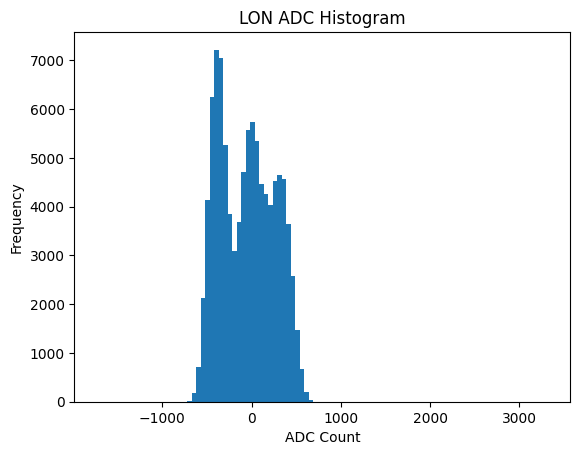

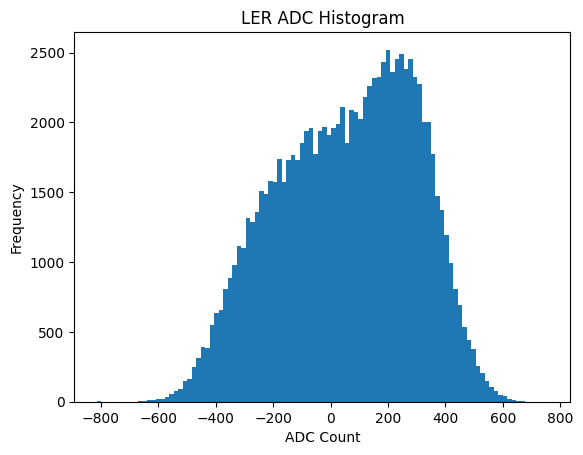

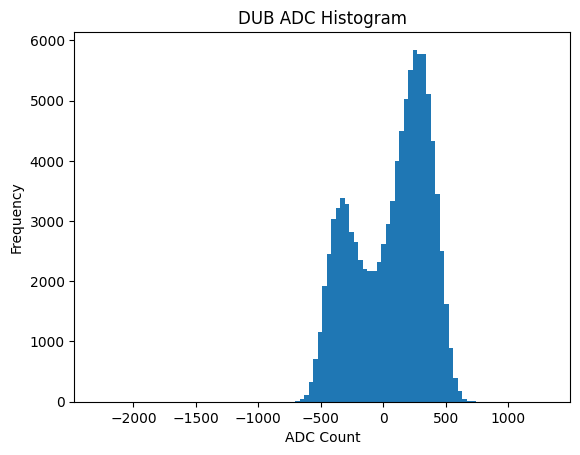

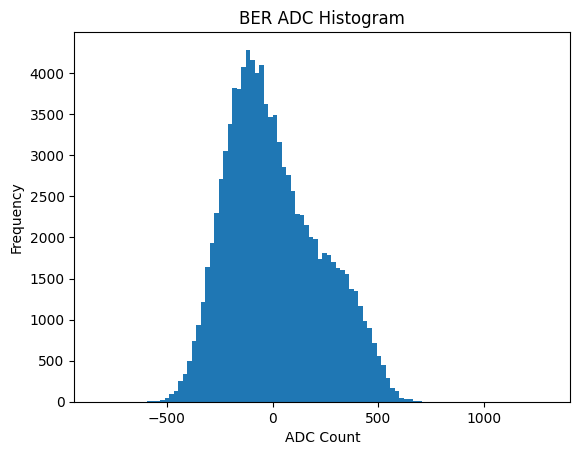

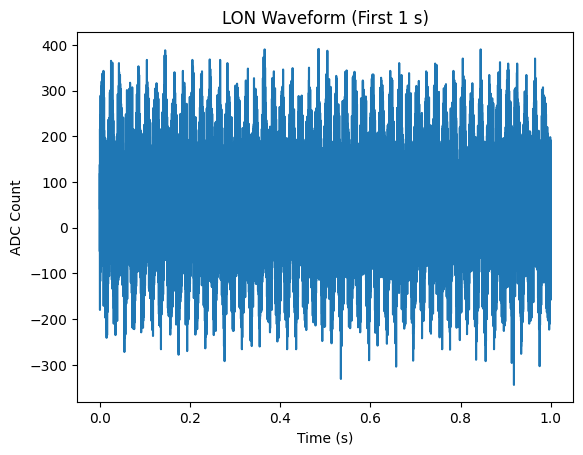

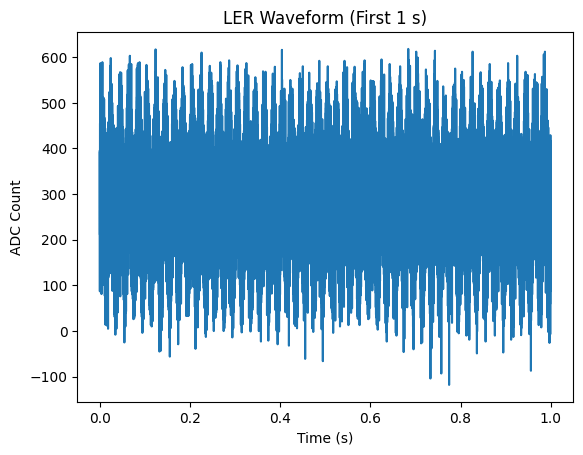

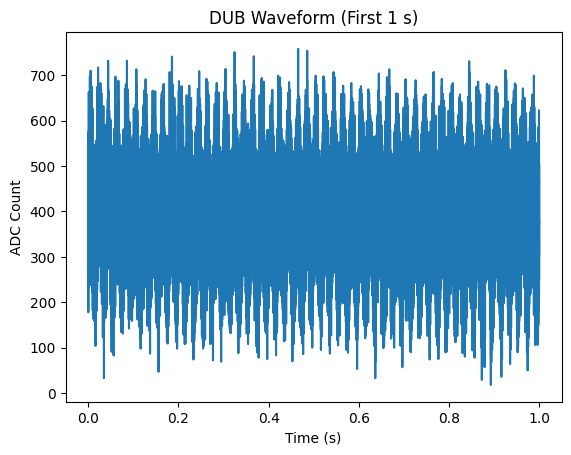

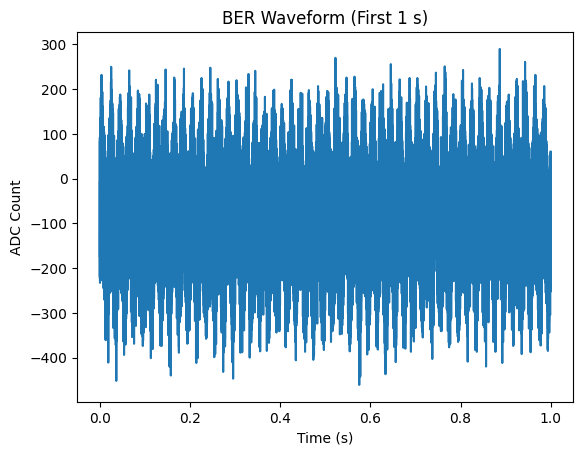

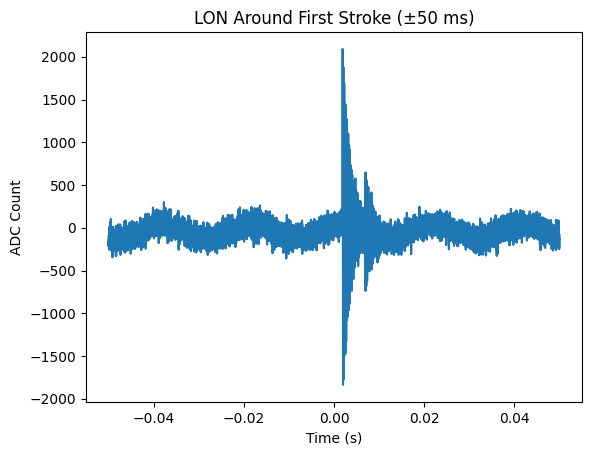

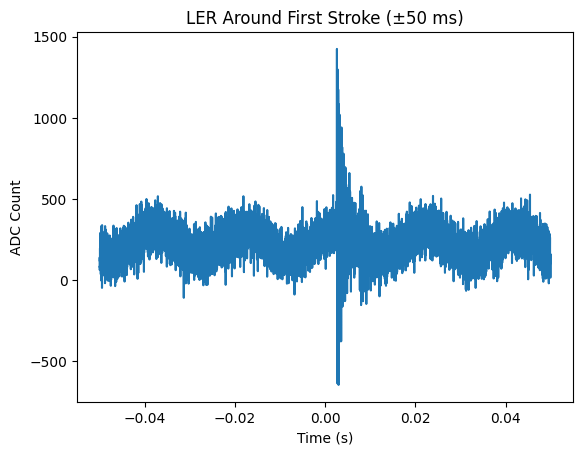

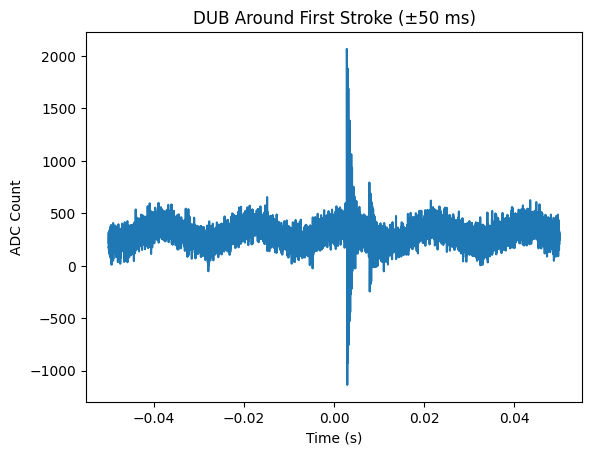

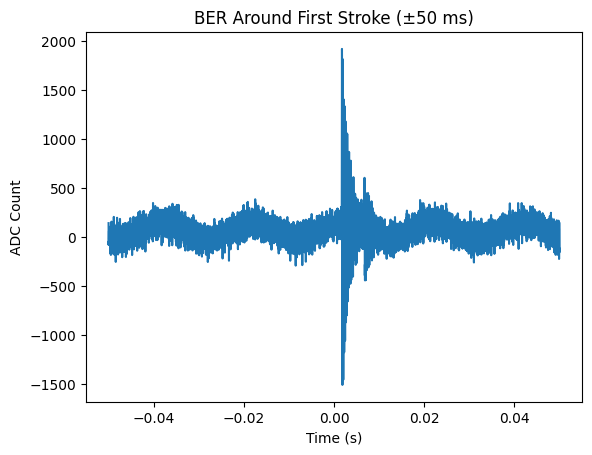

In [2]:
# === Summary Statistics (4-Station) ===
import numpy as np
import matplotlib.pyplot as plt

print("Sampling rate (Hz):", FS)
print("Total samples:", quantized[next(iter(quantized))].shape[0])
print("Duration (s):", quantized[next(iter(quantized))].shape[0] / FS)
print("Samples per minute:", FS * 60)
print()

# Per-station info
print("Per-station ADC stats:")
for name, arr in quantized.items():
    print(f"  {name:3s}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min()}, max={arr.max()}, mean={arr.mean():.2f}, std={arr.std():.2f}")
print()

# Flash & stroke timing stats
#  — pull all stroke times out of `events`
flash_times = np.sort(np.hstack([ev['stroke_times'] for ev in events]))
intervals   = np.diff(flash_times) if flash_times.size>1 else np.array([])
print("Total individual strokes:", flash_times.size)
if intervals.size>0:
    print(f"Inter-stroke intervals (s): mean={intervals.mean():.2f}, "
          f"median={np.median(intervals):.2f}, std={intervals.std():.2f}")
print()

# === Plots ===

# ADC histograms (downsampled)
for name, arr in quantized.items():
    sample = arr[:: max(1, len(arr)//100000)]
    plt.figure()
    plt.hist(sample, bins=100)
    plt.title(f"{name} ADC Histogram")
    plt.xlabel("ADC Count")
    plt.ylabel("Frequency")
    plt.show()

# First second waveforms
s1 = int(FS * 1)
time1 = np.arange(s1) / FS
for name, arr in quantized.items():
    plt.figure()
    plt.plot(time1, arr[:s1])
    plt.title(f"{name} Waveform (First 1 s)")
    plt.xlabel("Time (s)")
    plt.ylabel("ADC Count")
    plt.show()

# Zoom ±50 ms around first stroke
if flash_times.size > 0:
    window = int(0.05 * FS)
    i0 = int(flash_times[0] * FS)
    t_zoom = np.arange(-window, window) / FS
    for name, arr in quantized.items():
        start = max(0, i0 - window)
        end   = min(len(arr), i0 + window)
        seg   = arr[start:end]
        plt.figure()
        plt.plot(t_zoom[:len(seg)], seg)
        plt.title(f"{name} Around First Stroke (±50 ms)")
        plt.xlabel("Time (s)")
        plt.ylabel("ADC Count")
        plt.show()



Sampling rate: 109375 Hz
Total samples: 34657100
Total duration: 316.86 s  (5.28 min)
Samples per minute: 6562500

Per-station ADC stats:
  LON: shape=(34657100,), dtype=int16, min=-8191, max=8191, μ=-53.6, σ=306.8
  LER: shape=(34657100,), dtype=int16, min=-4427, max=5330, μ=56.0, σ=239.1
  DUB: shape=(34657100,), dtype=int16, min=-3637, max=4656, μ=62.8, σ=294.0
  BER: shape=(34657100,), dtype=int16, min=-2445, max=3079, μ=7.8, σ=222.0

Total stroke events: 28
Inter-stroke intervals (s): μ=9.80, med=0.05, σ=14.56

First 10 strokes:
 stroke_time_s       lat       lon
     19.962898 54.552223  6.446350
     68.471434 56.070181 -0.123866
     68.486879 56.070181 -0.123866
     68.535407 56.070181 -0.123866
     79.552232 49.839056 -2.584658
     85.905536 58.971690  1.727038
     98.979128 56.688542  3.152026
     98.991500 56.688542  3.152026
    111.653911 52.324159 -1.649477
    118.872377 54.419781  3.593701

Detection at stroke times:
 stroke_time_s       lat       lon  det_LON  de

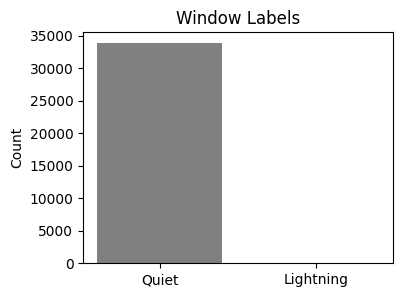

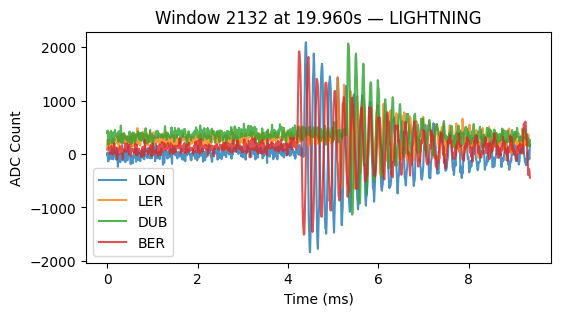

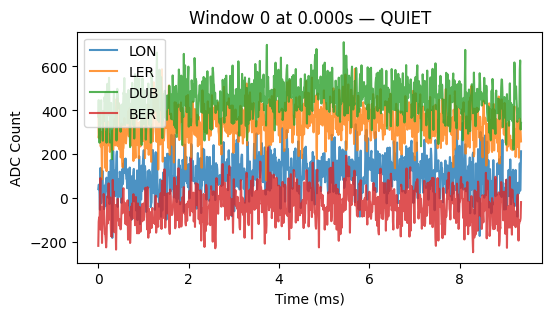

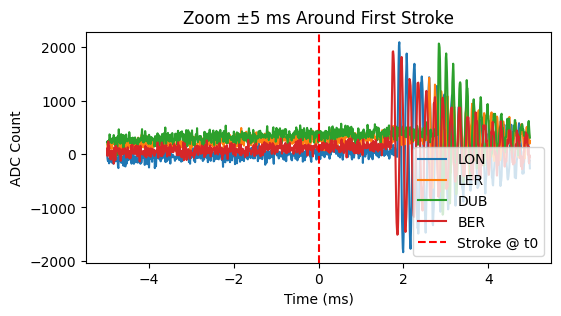

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === METADATA & SUMMARY ===
print(f"Sampling rate: {FS} Hz")
N = quantized[next(iter(quantized))].shape[0]
print(f"Total samples: {N}")
T = N / FS
print(f"Total duration: {T:.2f} s  ({T/60:.2f} min)")
print(f"Samples per minute: {FS*60:.0f}")
print()

# Per-station info
print("Per-station ADC stats:")
for name, arr in quantized.items():
    print(f"  {name:3s}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min()}, max={arr.max()}, μ={arr.mean():.1f}, σ={arr.std():.1f}")
print()

# === EVENT-LEVEL LABELS ===
# pull stroke times from 'events' instead of 'times'
stroke_times = np.sort(np.hstack([ev['stroke_times'] for ev in events]))
intervals    = np.diff(stroke_times) if stroke_times.size>1 else np.array([])
print(f"Total stroke events: {stroke_times.size}")
if intervals.size:
    print(f"Inter-stroke intervals (s): μ={intervals.mean():.2f}, "
          f"med={np.median(intervals):.2f}, σ={intervals.std():.2f}")
print()

# Build DataFrame of strokes
df_strokes = pd.DataFrame({
    'stroke_time_s': stroke_times,
    'lat': np.hstack([[ev['lat']]*len(ev['stroke_times']) for ev in events]),
    'lon': np.hstack([[ev['lon']]*len(ev['stroke_times']) for ev in events])
})
print("First 10 strokes:")
print(df_strokes.head(10).to_string(index=False))
print()

# === STATION DETECTION AT STROKES ===
pre_samples = int(pre_sec * FS)
df_detect = df_strokes.copy()
for name in stations:
    noise_std = quantized[name][:pre_samples].astype(float).std()
    thresh    = 3 * noise_std
    det_list  = []
    for t in stroke_times:
        idx = int(t * FS)
        val = quantized[name][idx] if idx < N else 0
        det_list.append(abs(val) >= thresh)
    df_detect[f"det_{name}"] = det_list

print("Detection at stroke times:")
print(df_detect.head(10).to_string(index=False))
print()

for name in stations:
    rate = df_detect[f"det_{name}"].mean() * 100
    print(f"{name} detection rate: {rate:.1f}%")
print()

# === WINDOW-LEVEL LABELING ===
W      = 1024
n_win  = N // W
starts = (np.arange(n_win) * W) / FS
stroke_samps = (stroke_times * FS).astype(int)
labels = [
    ((stroke_samps >= i*W) & (stroke_samps < (i+1)*W)).any()
    for i in range(n_win)
]
df_win = pd.DataFrame({
    'win_idx':      np.arange(n_win, dtype=int),
    'start_time_s': starts,
    'label':        np.array(labels, dtype=int)
})
counts = df_win['label'].value_counts().sort_index()
print(f"Total windows: {n_win}, quiet={counts.get(0,0)}, lightning={counts.get(1,0)}")
print("First 10 windows:")
print(df_win.head(10).to_string(index=False))
print()

# Plot window label counts
plt.figure(figsize=(4,3))
plt.bar(['Quiet','Lightning'], [counts.get(0,0), counts.get(1,0)], color=['gray','orange'])
plt.title("Window Labels")
plt.ylabel("Count")
plt.show()

# === PLOT EXAMPLES ===
time_ms = (np.arange(W) / FS) * 1e3

# First lightning window
row_pos = df_win[df_win.label==1].iloc[0]
idx_pos = int(row_pos.win_idx)
t0_pos  = row_pos.start_time_s
plt.figure(figsize=(6,3))
for name in stations:
    seg = quantized[name][idx_pos*W : (idx_pos+1)*W]
    plt.plot(time_ms, seg, label=name, alpha=0.8)
plt.title(f"Window {idx_pos} at {t0_pos:.3f}s — LIGHTNING")
plt.xlabel("Time (ms)")
plt.ylabel("ADC Count")
plt.legend()
plt.show()

# First quiet window
row_q = df_win[df_win.label==0].iloc[0]
idx_q = int(row_q.win_idx)
t0_q  = row_q.start_time_s
plt.figure(figsize=(6,3))
for name in stations:
    seg = quantized[name][idx_q*W : (idx_q+1)*W]
    plt.plot(time_ms, seg, label=name, alpha=0.8)
plt.title(f"Window {idx_q} at {t0_q:.3f}s — QUIET")
plt.xlabel("Time (ms)")
plt.ylabel("ADC Count")
plt.legend()
plt.show()

# Zoom ±5 ms around first stroke
if stroke_times.size:
    t0   = stroke_times[0]
    i0   = int(t0 * FS)
    zoom = int(0.005 * FS)
    tt   = (np.arange(-zoom, zoom) / FS) * 1e3
    plt.figure(figsize=(6,3))
    for name in stations:
        seg = quantized[name][max(0, i0-zoom) : min(N, i0+zoom)]
        plt.plot(tt[:len(seg)], seg, label=name)
    plt.axvline(0, color='red', linestyle='--', label='Stroke @ t0')
    plt.title("Zoom ±5 ms Around First Stroke")
    plt.xlabel("Time (ms)")
    plt.ylabel("ADC Count")
    plt.legend()
    plt.show()



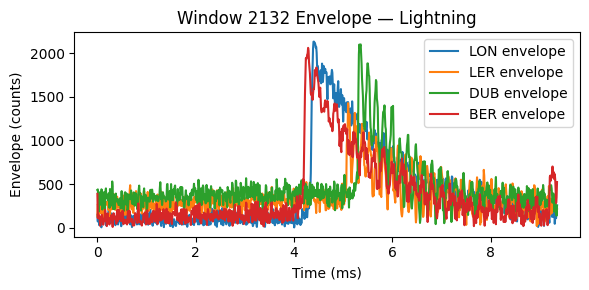

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# =============================================================================
# Envelope plot for the first detected lightning window
# (after you've run your updated summary & detector cells)
# =============================================================================

# 1) Pick which lightning window to plot (0 = first)
nth_lightning = 0
# get the window index from df_win
idx = int(df_win[df_win.label == 1].iloc[nth_lightning]['win_idx'])

# 2) Time axis for one window, in ms
W   = 1024
tms = (np.arange(W) / FS) * 1e3

# 3) Plot analytic‐signal envelope for each station
plt.figure(figsize=(6, 3))
for name in station_order:
    # extract that window
    seg = quantized[name][idx*W : (idx+1)*W].astype(float)
    env = np.abs(hilbert(seg))
    plt.plot(tms, env, label=f"{name} envelope")
plt.title(f"Window {idx} Envelope — Lightning")
plt.xlabel("Time (ms)")
plt.ylabel("Envelope (counts)")
plt.legend()
plt.tight_layout()
plt.show()



In [5]:
# ============================================================
# Cell 2 – Robust stroke‐by‐stroke Hilbert‐envelope detector
#            + 50%‐overlap windows + percentile thresholds
#            (earliest‐arrival indexing)
# ============================================================
import numpy as np
from scipy.signal import hilbert
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

# ── Parameters ──────────────────────────────────────────────
FS         = float(FS)         # sampling rate from Cell 1
WIN        = 1024              # window size
HOP        = WIN // 2          # 50% overlap hop
STATIONS   = station_order     # ['LON','LER','DUB','BER']
PCT_THRESH = 99.9              # top 0.1% of envelope peaks
MIN_STN    = 2                 # require ≥2 stations → stroke detection
TOL_WIN    = 1                 # ±1‐window tolerance for scoring

# ── 1) Compute Hilbert‐envelope window peaks per station ────
def window_peaks(raw):
    env   = np.abs(hilbert(raw.astype(float)))
    n_win = (len(env) - WIN)//HOP + 1
    peaks = np.empty(n_win, float)
    for i in range(n_win):
        s = i * HOP
        peaks[i] = env[s:s+WIN].max()
    return peaks

peaks = {nm: window_peaks(quantized[nm]) for nm in STATIONS}
n_win = min(len(v) for v in peaks.values())

# ── 2) Threshold by percentile of all windows ───────────────
hot = {}
print("Per-station thresholds & flagged windows:")
for nm in STATIONS:
    p    = peaks[nm][:n_win]
    thr  = np.percentile(p, PCT_THRESH)
    mask = p > thr
    hot[nm] = mask
    print(f" {nm}: thr={thr:6.1f}, flagged={mask.sum():5d} / {n_win}")

# ── 3) Build stroke_samples using earliest arrival across stations ─
stroke_samples = []
for ev in events:
    for t0 in ev['stroke_times']:
        arrivals = []
        for nm in STATIONS:
            geo  = stations[nm]
            dist = hav(ev['lat'], ev['lon'], geo['lat'], geo['lon'])
            i0   = int((t0 + dist/300_000.0) * FS)
            arrivals.append(i0)
        stroke_samples.append(min(arrivals))
stroke_samples = np.array(stroke_samples)
n_events      = len(stroke_samples)
stroke_truth  = np.ones(n_events, bool)

# ── 4) Count station hits per stroke (within ±TOL_WIN windows) ─
counts = np.zeros(n_events, int)
for nm in STATIONS:
    mask = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        w0 = max(0, w - TOL_WIN)
        w1 = min(n_win, w + TOL_WIN + 1)
        if mask[w0:w1].any():
            counts[j] += 1

print("\nStations ≥thr per stroke:")
for k, v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ── 5) Station-level stroke metrics ───────────────────────────
print("\nStation-level stroke detection:")
print("stn   TP   FP   FN     P     R    F1")
for nm in STATIONS:
    hits = np.array([
        hot[nm][max(0, min(n_win-1, i0//HOP))]
        for i0 in stroke_samples
    ])
    tn, fp, fn, tp = confusion_matrix(stroke_truth, hits, labels=[False,True]).ravel()
    P = precision_score(stroke_truth, hits, zero_division=0)
    R = recall_score   (stroke_truth, hits, zero_division=0)
    F = f1_score       (stroke_truth, hits, zero_division=0)
    print(f"{nm:>3} {tp:4d} {fp:4d} {fn:4d} {P:8.3f} {R:6.3f} {F:6.3f}")

# ── 6) Network-level stroke metrics (≥MIN_STN stations) ──────
stroke_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(
    stroke_truth, stroke_pred, labels=[False,True]
).ravel()
P_net = precision_score(stroke_truth, stroke_pred, zero_division=0)
R_net = recall_score   (stroke_truth, stroke_pred, zero_division=0)
F_net = f1_score       (stroke_truth, stroke_pred, zero_division=0)

print(f"\nNetwork (≥{MIN_STN} stn) stroke-wise:")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f" P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")


Per-station thresholds & flagged windows:
 LON: thr=2125.6, flagged=   68 / 67688
 LER: thr=1252.5, flagged=   68 / 67688
 DUB: thr=1907.9, flagged=   67 / 67688
 BER: thr=1378.8, flagged=   68 / 67688

Stations ≥thr per stroke:
   2 stations → 9 strokes
   3 stations → 12 strokes
   4 stations → 7 strokes

Station-level stroke detection:
stn   TP   FP   FN     P     R    F1
LON   20    0    8    1.000  0.714  0.833
LER   24    0    4    1.000  0.857  0.923
DUB   16    0   12    1.000  0.571  0.727
BER   21    0    7    1.000  0.750  0.857

Network (≥2 stn) stroke-wise:
 TP=28  FP=0  FN=0  TN=0
 P=1.000  R=1.000  F1=1.000



Stroke table (first 12 rows):
 #  t_true    t_est   err_ms loc_err_km dLON_true dLON_est n_stn    d_LON    d_LER    d_DUB    d_BER
 0  19.963                                                                                          
 1  68.471     68.4  -71.809      2.649   508.181  506.839   3.0           459.093  497.654  957.632
 2  68.487                                                                                          
 3  68.535                                                                                          
 4  79.552                                                                                          
 5  85.906                                                                                          
 6  98.979                                                                                          
 7  98.991   98.811  -180.72     15.066   614.954  624.597   3.0  624.597  462.152           795.313
 8 111.654  111.396 -257.925     11.327   139.295  149.396  

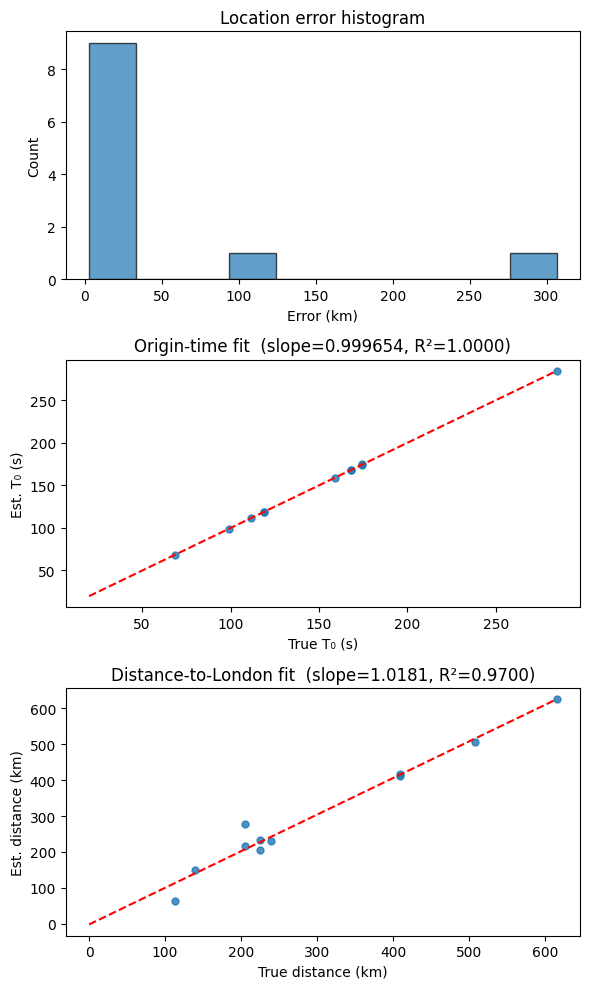

In [6]:
# ============================================================
# Cell 3 – Compact stroke table + time/location regressions
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import hilbert

plt.rcParams["font.family"] = "DejaVu Sans"
c, Re = 299_792.458, 6371.0            # km s‑1, Earth radius

# ---------- helpers ---------------------------------------------------------
def ll_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    cl = np.cos(lat)
    return np.array([Re*cl*np.cos(lon),
                     Re*cl*np.sin(lon),
                     Re*np.sin(lat)])

def hav_km(la1, lo1, la2, lo2):
    φ1, φ2 = map(np.radians, (la1, la2))
    dφ = φ2-φ1; dλ = np.radians(lo2-lo1)
    a = np.sin(dφ/2)**2 + np.cos(φ1)*np.cos(φ2)*np.sin(dλ/2)**2
    return 2*Re*np.arcsin(np.sqrt(a))

st_xyz = {nm: ll_xyz(stations[nm]['lat'], stations[nm]['lon']) for nm in STATIONS}

def pick_arrival(nm, s0):
    seg = quantized[nm][max(0,s0-WIN):min(len(quantized[nm]),s0+WIN)].astype(float)
    env = np.abs(hilbert(seg)); idx = env.argmax()
    return (max(0,s0-WIN)+idx)/FS

# ---------- build arrival dictionary from Cell‑2 results --------------------
arrivals = []
for j,s0 in enumerate(stroke_samples):
    d={}
    for nm in STATIONS:
        w=s0//HOP
        if w<n_win and hot[nm][w]:
            d[nm]=pick_arrival(nm,int(s0))
    arrivals.append(d)

# ---------- TOA least‑squares (robust) -------------------------------------
def solve_toa(a):
    if len(a)<3: return None
    st = list(a); t = np.array([a[n] for n in st]); S=np.stack([st_xyz[n] for n in st])
    r = S[np.argsort(t)[:3]].mean(0); T0 = t.min() - np.linalg.norm(S[np.argmin(t)]-r)/c
    for _ in range(8):
        d = np.linalg.norm(S-r,axis=1); d[d==0]+=1e-6
        res = t-(T0+d/c)
        if np.sqrt((res**2).mean())*1e3<0.2: break
        J=np.empty((len(st),4)); J[:,:3]=-(S-r)/(c*d)[:,None]; J[:,3]=-1
        delta,*_=np.linalg.lstsq(J,res,rcond=None);
        if np.linalg.norm(delta[:3])>500: return None
        r+=delta[:3]; T0+=delta[3]
    la=np.degrees(np.arcsin(r[2]/np.linalg.norm(r)))
    lo=np.degrees(np.arctan2(r[1],r[0]))
    if hav_km(la,lo,lat0,lon0)>800: return None
    return T0,la,lo

# ---------- truth vectors ---------------------------------------------------
tru_t, tru_la, tru_lo = [],[],[]
for ev in events:
    for t0 in ev['stroke_times']:
        tru_t.append(t0); tru_la.append(ev['lat']); tru_lo.append(ev['lon'])
tru_t, tru_la, tru_lo = map(np.array, (tru_t, tru_la, tru_lo))

# ---------- build neat table ------------------------------------------------
records=[]
for k,(t_true,la_true,lo_true) in enumerate(zip(tru_t,tru_la,tru_lo)):
    sol=solve_toa(arrivals[k])
    row={'#':k,'t_true':t_true}
    if sol:
        T0,la,lo = sol
        row.update(t_est=T0,
                   err_ms=(T0-t_true)*1e3,
                   dLON_true=hav_km(la_true,lo_true,
                                    stations['LON']['lat'],stations['LON']['lon']),
                   dLON_est =hav_km(la,lo,
                                    stations['LON']['lat'],stations['LON']['lon']),
                   loc_err_km=hav_km(la,lo,la_true,lo_true),
                   n_stn=len(arrivals[k]))
        for nm in STATIONS:
            row[f'd_{nm}']=hav_km(la,lo,stations[nm]['lat'],stations[nm]['lon']) \
                           if nm in arrivals[k] else np.nan
    else:
        row.update({col:np.nan for col in
            ['t_est','err_ms','dLON_true','dLON_est','loc_err_km','n_stn']+[f'd_{n}'for n in STATIONS]})
    records.append(row)

df=pd.DataFrame(records)
# Formatting
pd.set_option('display.max_columns', None)
show_cols=['#','t_true','t_est','err_ms','loc_err_km','dLON_true','dLON_est','n_stn']+[f'd_{n}' for n in STATIONS]
print("\nStroke table (first 12 rows):")
print(df[show_cols].head(12).round(3).fillna('').to_string(index=False))

# ---------- regressions & plots --------------------------------------------
mask=df.t_est.notna()
# time regression
coef=np.polyfit(df.loc[mask,'t_true'],df.loc[mask,'t_est'],1);
R2 = np.corrcoef(df.loc[mask,'t_true'],df.loc[mask,'t_est'])[0,1]**2

# distance‑to‑London regression
maskL=df.dLON_est.notna()
coefL=np.polyfit(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'],1)
R2L = np.corrcoef(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'])[0,1]**2

# plots
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(6,10))

ax1.hist(df.loc[mask,'loc_err_km'],bins=10,edgecolor='k',alpha=.7)
ax1.set_title("Location error histogram"); ax1.set_xlabel("Error (km)"); ax1.set_ylabel("Count")

# time regression
ax2.scatter(df.loc[mask,'t_true'],df.loc[mask,'t_est'],s=25,alpha=.8)
x=np.linspace(df.t_true.min(),df.t_true.max(),100)
ax2.plot(x,coef[0]*x+coef[1],'r--')
ax2.set_title(f"Origin‑time fit  (slope={coef[0]:.6f}, R²={R2:.4f})")
ax2.set_xlabel("True T₀ (s)"); ax2.set_ylabel("Est. T₀ (s)")

# distance‑to‑London regression
ax3.scatter(df.loc[maskL,'dLON_true'],df.loc[maskL,'dLON_est'],s=25,alpha=.8)
xL=np.linspace(0,df.dLON_true.max(),100)
ax3.plot(xL,coefL[0]*xL+coefL[1],'r--')
ax3.set_title(f"Distance‑to‑London fit  (slope={coefL[0]:.4f}, R²={R2L:.4f})")
ax3.set_xlabel("True distance (km)"); ax3.set_ylabel("Est. distance (km)")

plt.tight_layout(); plt.show()


In [7]:
# ============================================================
# Cell 2 – Pure‑NCD detector (global‑noise baseline, rich report)
# ============================================================
import numpy as np, bz2, tqdm.auto as tq
from functools import lru_cache
from collections import Counter
from scipy.stats import describe
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ── parameters you can tweak ─────────────────────────────────
WIN, HOP   = 1024, 512        # 9.4 ms, 50 % overlap
BASE_PCT   = 5                # use lowest‑entropy 5 % to pick baseline
PCT_THR    = 98.5             # percentile threshold on *all* windows
Z_SIGMA    = 3.5              # μ + Z σ clamp
MIN_STN    = 2                # network requirement
STN        = station_order

# ── helpers ─────────────────────────────────────────────────
@lru_cache(maxsize=None)
def c_size(b: bytes) -> int:
    return len(bz2.compress(b, 9))

def ncd(a: bytes, b: bytes, Ca: int, Cb: int) -> float:
    return (c_size(a+b) - min(Ca, Cb)) / max(Ca, Cb)

def sign_bits(arr: np.ndarray) -> bytes:
    diff = np.diff(arr.astype(np.int16), prepend=arr[0])
    return np.packbits((diff > 0).astype(np.uint8)).tobytes()

def win_view(sig: np.ndarray, W: int, H: int):
    n = (len(sig) - W) // H + 1
    return np.lib.stride_tricks.as_strided(
        sig,
        shape=(n, W),
        strides=(sig.strides[0]*H, sig.strides[0])
    )

# -------- 1) build per‑station NCD & metadata ---------------
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STN)
meta   = {}             # store everything here

print(f"\nWindow = {WIN} samples  ({WIN/FS*1e3:.2f} ms)   hop = {HOP} samples")
print(f"Total windows analysed per station: {n_win:,}\n")

for nm in STN:
    sig  = quantized[nm]
    wmat = win_view(sig, WIN, HOP)

    # pass‑1: compressed size of each window
    comp_sz = np.empty(n_win, np.uint16)
    for i in tq.trange(n_win, desc=f"{nm} size pass", leave=False):
        comp_sz[i] = c_size(sign_bits(wmat[i]))

    # choose baseline = median of lowest BASE_PCT %
    k = max(1, int(BASE_PCT/100 * n_win))
    low_idx = np.argpartition(comp_sz, k)[:k]
    base_idx = low_idx[np.argsort(comp_sz[low_idx])[k//2]]
    base_b   = sign_bits(wmat[base_idx])
    Cb       = c_size(base_b)

    # pass‑2: NCD of every window vs baseline
    ncd_vec = np.empty(n_win, float)
    for i in tq.trange(n_win, desc=f"{nm} NCD pass", leave=False):
        wb = sign_bits(wmat[i])
        ncd_vec[i] = ncd(wb, base_b, comp_sz[i], Cb)

    # statistics & threshold
    stats = describe(ncd_vec)
    pct_thr = np.percentile(ncd_vec, PCT_THR)
    z_thr   = stats.mean + Z_SIGMA*stats.variance**0.5
    thr     = min(pct_thr, z_thr)
    hot     = ncd_vec > thr

    meta[nm] = dict(
        base_idx   = base_idx,
        base_size  = Cb,
        min_size   = comp_sz.min(),
        max_size   = comp_sz.max(),
        ncd        = ncd_vec,
        hot        = hot,
        thr_pct    = pct_thr,
        thr_z      = z_thr,
        thr_used   = thr,
        desc       = stats,
        hot_mu     = ncd_vec[hot].mean() if hot.any() else np.nan,
        hot_sd     = ncd_vec[hot].std(ddof=0) if hot.any() else np.nan,
        top5       = np.sort(ncd_vec)[-5:][::-1]
    )

# -------- 2) pretty report ----------------------------------
for nm in STN:
    r = meta[nm]
    print(f"\n{nm} — baseline window #{r['base_idx']}  "
          f"C={r['base_size']} B  (min={r['min_size']} B  max={r['max_size']} B)")
    print(f"     NCD: μ={r['desc'].mean:.4f}  σ={np.sqrt(r['desc'].variance):.4f}  "
          f"median={np.median(r['ncd']):.4f}  p1={np.percentile(r['ncd'],1):.4f}  "
          f"p99={np.percentile(r['ncd'],99):.4f}")
    print(f"     thr_pct={r['thr_pct']:.4f}  thr_z={r['thr_z']:.4f}  "
          f"→ thr_used={r['thr_used']:.4f}")
    print(f"     hot windows = {r['hot'].sum():,}  "
          f"μ_hot={r['hot_mu']:.4f}  σ_hot={r['hot_sd']:.4f}")
    print(f"     top‑5 NCD windows: {np.round(r['top5'],4)}")

# -------- 3) build stroke list ------------------------------
stroke_idx = [min(int((t0 + hav(ev['lat'],ev['lon'],
                                stations[n]['lat'],stations[n]['lon'])/300000)*FS)
                    for n in STN)
              for ev in events for t0 in ev['stroke_times']]
stroke_idx = np.array(stroke_idx)
truth = np.ones(len(stroke_idx), bool)

# -------- 4) per‑stroke station hits ------------------------
hits = np.zeros((len(STN), len(stroke_idx)), bool)
for s,nm in enumerate(STN):
    hot = meta[nm]['hot']
    for j,i0 in enumerate(stroke_idx):
        w = i0 // HOP
        hits[s, j] = hot[max(0, w-1):min(len(hot), w+2)].any()

cnt = hits.sum(axis=0)

print("\nStations ≥ thr per stroke:")
for k,v in sorted(Counter(cnt).items()):
    print(f"  {k} stations → {v} strokes")

# -------- 5) metrics ----------------------------------------
print("\nStation‑level stroke detection:")
print("stn  TP  FP  FN   P      R      F1")
for s,nm in enumerate(STN):
    pred = hits[s]
    tn,fp,fn,tp = confusion_matrix(truth, pred, labels=[False,True]).ravel()
    P = precision_score(truth, pred, zero_division=0)
    R = recall_score   (truth, pred, zero_division=0)
    F = f1_score       (truth, pred, zero_division=0)
    print(f"{nm:>3} {tp:3d} {fp:3d} {fn:3d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = cnt >= MIN_STN
tn,fp,fn,tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
P_net = precision_score(truth, net_pred, zero_division=0)
R_net = recall_score   (truth, net_pred, zero_division=0)
F_net = f1_score       (truth, net_pred, zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn)  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"P={P_net:.3f}  R={R_net:.3f}  F1={F_net:.3f}")



Window = 1024 samples  (9.36 ms)   hop = 512 samples
Total windows analysed per station: 67,688



/Users/johngoodacre/leela-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
                                                                       


LON — baseline window #40314  C=198 B  (min=187 B  max=214 B)
     NCD: μ=0.7318  σ=0.0382  median=0.7317  p1=0.6714  p99=0.8317
     thr_pct=0.8261  thr_z=0.8654  → thr_used=0.8261
     hot windows = 996  μ_hot=0.8407  σ_hot=0.0151
     top‑5 NCD windows: [0.9659 0.9646 0.9455 0.9109 0.9109]

LER — baseline window #5358  C=198 B  (min=187 B  max=214 B)
     NCD: μ=0.7355  σ=0.0396  median=0.7343  p1=0.6732  p99=0.8374
     thr_pct=0.8317  thr_z=0.8742  → thr_used=0.8317
     hot windows = 1,000  μ_hot=0.8464  σ_hot=0.0157
     top‑5 NCD windows: [0.966  0.9463 0.9455 0.9317 0.9303]

DUB — baseline window #44430  C=198 B  (min=181 B  max=213 B)
     NCD: μ=0.7333  σ=0.0383  median=0.7330  p1=0.6731  p99=0.8341
     thr_pct=0.8284  thr_z=0.8674  → thr_used=0.8284
     hot windows = 983  μ_hot=0.8423  σ_hot=0.0151
     top‑5 NCD windows: [0.985  0.966  0.9453 0.936  0.9343]

BER — baseline window #23934  C=198 B  (min=187 B  max=215 B)
     NCD: μ=0.7171  σ=0.0323  median=0.7079  p1=0.6

In [8]:
# ============================================================
# Cell 3 – Isolation‑Forest detector with rich signal features
#           (STA/LTA • Hilbert • spectral • wavelet • compress)
#           50 %‑overlap windows, per‑station & network scores
# ============================================================
import numpy as np, zlib, pywt, math, sys
from scipy.signal import hilbert, lfilter
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, confusion_matrix
)
from collections import Counter
from tqdm.auto import tqdm

# ── parameters (reuse values from previous cells) ────────────
WIN       = 1024
HOP       = WIN // 2
STATIONS  = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
CONTAM    = 0.003          # ≈0.3 % windows flagged per station

# ------------------------------------------------------------
def sta_lta(x: np.ndarray, sta=128, lta=1024):
    """Return STA/LTA ratio for centre of x (padding with edge value)."""
    if len(x) < lta:          # shouldn’t happen – WIN >= LTA
        return 1.0
    c   = len(x) // 2
    sta_mean = x[c-sta//2:c+sta//2].astype(float).mean()
    lta_mean = x[c-lta//2:c+lta//2].astype(float).mean()
    return sta_mean / (lta_mean + 1e-9)

def crest_factor(seg: np.ndarray):
    """peak / RMS over short (WIN/8) segment centred in window."""
    n = len(seg) // 8
    c = len(seg) // 2
    part = seg[c-n//2:c+n//2].astype(float)
    rms  = math.sqrt((part**2).mean()) + 1e-9
    return np.abs(part).max() / rms

def comp_ratio(seg: np.ndarray) -> float:
    raw  = seg.tobytes()
    comp = zlib.compress(raw, 6)
    return len(comp) / (len(raw) if len(raw) else 1)

# ------------------------------------------------------------
print(f"Building feature matrices...  WIN={WIN}, HOP={HOP}, overlap=50 %")
n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 13         # we will collect 13 features / window
features = {nm: np.empty((n_win, feat_dim), dtype=float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN // 2 + 1
    b25 = int(Nfft*0.25); b50=int(Nfft*0.50); b75=int(Nfft*0.75)
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w * HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        # 1‑3  : Hilbert envelope (peak, median, peak/median)
        peak_env = env_seg.max()
        med_env  = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        # 4‑5  : Energy + STA/LTA
        energy = float((seg_f**2).sum())
        stalta = sta_lta(env_seg)

        # 6‑7  : Crest factor (short segment) + global crest factor
        cf_short = crest_factor(seg_i16)
        cf_global= peak_env / (math.sqrt((seg_f**2).mean())+1e-9)

        # 8‑11 : FFT band‑power fractions
        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum() + 1e-9
        frac1 = P[:b25].sum()/totP
        frac2 = P[b25:b50].sum()/totP
        frac3 = P[b50:b75].sum()/totP
        frac4 = P[b75:].sum()/totP

        # 12‑13: Wavelet high/low frac + compression ratio
        coeffs = pywt.wavedec(seg_f, 'db4', level=3)
        details = coeffs[1:]     # D1‑D3
        highE = (details[0]**2).sum()
        lowE  = (details[-1]**2).sum()
        totE  = highE + lowE + 1e-9
        wave_hi = highE / totE
        comp_r  = comp_ratio(seg_i16)

        features[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            cf_short, cf_global,
            frac1, frac2, frac3, frac4,
            wave_hi, comp_r
        ]

# ------------------------------------------------------------
print("\nFitting Isolation Forest per station...")
hot = {}
for nm in STATIONS:
    X   = features[nm]
    # z‑score scaling to unit variance
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    iso = IsolationForest(
        n_estimators=150,
        max_samples='auto',
        contamination=CONTAM,
        bootstrap=False,
        random_state=42
    ).fit(Xs)
    yhat = iso.predict(Xs)   # -1 = anomaly
    hot[nm] = (yhat == -1)
    print(f" {nm}: windows flagged = {hot[nm].sum():5d} / {n_win} "
          f"(contam={CONTAM:.3%})")

# ------------------------------------------------------------
# stroke_samples, stroke_truth come from Cell 2
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j] += 1

print("\nStations ≥thr per stroke:")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection:")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net = precision_score(stroke_truth,net_pred,zero_division=0)
R_net = recall_score   (stroke_truth,net_pred,zero_division=0)
F_net = f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")



Building feature matrices...  WIN=1024, HOP=512, overlap=50 %



Fitting Isolation Forest per station...
 LON: windows flagged =   204 / 67688 (contam=0.300%)
 LER: windows flagged =   204 / 67688 (contam=0.300%)
 DUB: windows flagged =   204 / 67688 (contam=0.300%)
 BER: windows flagged =   204 / 67688 (contam=0.300%)

Stations ≥thr per stroke:
   3 stations → 9 strokes
   4 stations → 19 strokes

Station‑level stroke detection:
stn TP FP FN     P      R     F1
LON 28  0  0   1.000  1.000  1.000
LER 28  0  0   1.000  1.000  1.000
DUB 18  0 10   1.000  0.643  0.783
BER 25  0  3   1.000  0.893  0.943

Network (≥2 stn) stroke‑wise:
 TP=28 FP=0 FN=0 TN=0   P=1.000 R=1.000 F1=1.000


In [9]:
# ============================================================
# Cell 3 – Isolation‑Forest with Robust scaling + extra spectra
# ============================================================
import numpy as np, zlib, pywt, math, sys
from scipy.signal import hilbert
from sklearn.preprocessing import RobustScaler          # ► changed
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from collections import Counter

# ---------- configuration (same as before) ------------------
WIN, HOP   = 1024, 512
STATIONS   = station_order
FS         = float(FS)
TOL_WIN    = 1
BASE_CONT  = 0.003          # default contamination
MIN_STN    = 2
N_EST      = 150

# ---------- helper functions --------------------------------
def sta_lta(env, sta=128, lta=1024):
    c = len(env)//2
    return env[c-sta//2:c+sta//2].mean() / (env[c-lta//2:c+lta//2].mean()+1e-9)

def crest(seg):
    rms = math.sqrt((seg.astype(float)**2).mean()) + 1e-9
    return np.abs(seg).max()/rms

def comp_ratio(seg):
    raw = seg.tobytes()
    return len(zlib.compress(raw,6))/len(raw)

def spec_stats(seg_f):
    """return centroid, bandwidth and entropy over |FFT|²"""
    P = np.abs(np.fft.rfft(seg_f))**2
    P /= P.sum()+1e-12
    freqs = np.fft.rfftfreq(len(seg_f), d=1/FS)
    centroid = (freqs*P).sum()
    bandwidth= math.sqrt(((freqs-centroid)**2*P).sum())
    entropy  = -(P*np.log2(P+1e-12)).sum()
    return centroid, bandwidth, entropy

# ---------- feature extraction -------------------------------
print(f"Feature list:")
print("  peak_env, med_env, ratio_env, energy, sta/lta, "
      "crest_short, crest_glob, band1..4, wave_hi, comp_r, "
      "centroid, bw, ent")

n_win = min(((len(quantized[n]) - WIN)//HOP)+1 for n in STATIONS)
feat_dim = 16   # 13 old + 3 spectral stats
X_station = {nm: np.empty((n_win, feat_dim), float) for nm in STATIONS}

for nm in STATIONS:
    sig = quantized[nm]
    env = np.abs(hilbert(sig.astype(float)))
    Nfft = WIN//2+1
    borders = [int(Nfft*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm} windows", leave=False):
        s = w*HOP
        seg_i16 = sig[s:s+WIN]
        seg_f   = seg_i16.astype(float)
        env_seg = env[s:s+WIN]

        # Envelope features
        peak_env = env_seg.max(); med_env = np.median(env_seg)
        ratio_env= peak_env/(med_env+1e-9)

        # Energy & STA/LTA
        energy = (seg_f**2).sum(); stalta = sta_lta(env_seg)

        # Crest factors
        crest_s = crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16])
        crest_g = crest(seg_i16)

        # FFT band‑power fractions
        P = np.abs(np.fft.rfft(seg_f))**2
        totP = P.sum()+1e-9
        f1,f2,f3 = borders
        b1 = P[:f1].sum()/totP; b2=P[f1:f2].sum()/totP
        b3 = P[f2:f3].sum()/totP; b4=P[f3:].sum()/totP

        # Wavelet & compression
        hi = pywt.wavedec(seg_f,'db4',level=3)[1]; lo = pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi = (hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r = comp_ratio(seg_i16)

        # Spectral centroid / bandwidth / entropy
        cent, bw, ent = spec_stats(seg_f)

        X_station[nm][w] = [
            peak_env, med_env, ratio_env,
            energy, stalta,
            crest_s, crest_g,
            b1,b2,b3,b4,
            wave_hi, comp_r,
            cent, bw, ent
        ]

# ---------- fit Isolation Forest per station ----------------
hot = {}
for nm in STATIONS:
    X = X_station[nm]
    rob = RobustScaler().fit(X)        # ► changed scaler
    Xs  = rob.transform(X)

    # OPTIONAL: allow weak stations a bit more contamination
    contam = BASE_CONT if nm in ('LON','LER') else BASE_CONT*1.5

    iso  = IsolationForest(
              n_estimators=N_EST,
              contamination=contam,
              random_state=42
           ).fit(Xs)
    hot[nm] = (iso.predict(Xs) == -1)
    print(f"{nm}: windows flagged = {hot[nm].sum():4d} / {n_win} (contam {contam:.3%})")

# ---------- per‑stroke scoring ------------------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STATIONS:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

print("\nStations ≥thr per stroke:")
for k,v in sorted(Counter(counts).items()):
    print(f"  {k:2d} stations → {v} strokes")

print("\nStation‑level stroke detection:")
print("stn TP FP FN     P      R     F1")
for nm in STATIONS:
    pred = np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(stroke_truth,pred,labels=[False,True]).ravel()
    P = precision_score(stroke_truth,pred,zero_division=0)
    R = recall_score   (stroke_truth,pred,zero_division=0)
    F = f1_score       (stroke_truth,pred,zero_division=0)
    print(f"{nm:>3} {tp:2d} {fp:2d} {fn:2d}  {P:6.3f} {R:6.3f} {F:6.3f}")

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(stroke_truth,net_pred,labels=[False,True]).ravel()
P_net=precision_score(stroke_truth,net_pred,zero_division=0)
R_net=recall_score   (stroke_truth,net_pred,zero_division=0)
F_net=f1_score       (stroke_truth,net_pred,zero_division=0)
print(f"\nNetwork (≥{MIN_STN} stn) stroke‑wise:")
print(f" TP={tp} FP={fp} FN={fn} TN={tn}   P={P_net:.3f} R={R_net:.3f} F1={F_net:.3f}")


Feature list:
  peak_env, med_env, ratio_env, energy, sta/lta, crest_short, crest_glob, band1..4, wave_hi, comp_r, centroid, bw, ent


LON: windows flagged =  204 / 67688 (contam 0.300%)
LER: windows flagged =  204 / 67688 (contam 0.300%)
DUB: windows flagged =  305 / 67688 (contam 0.450%)
BER: windows flagged =  305 / 67688 (contam 0.450%)

Stations ≥thr per stroke:
   3 stations → 9 strokes
   4 stations → 19 strokes

Station‑level stroke detection:
stn TP FP FN     P      R     F1
LON 28  0  0   1.000  1.000  1.000
LER 28  0  0   1.000  1.000  1.000
DUB 20  0  8   1.000  0.714  0.833
BER 26  0  2   1.000  0.929  0.963

Network (≥2 stn) stroke‑wise:
 TP=28 FP=0 FN=0 TN=0   P=1.000 R=1.000 F1=1.000


In [10]:
# ============================================================
# Cell 3‑EIF‑isotree  (API‑robust)
# ============================================================
import os, warnings, zlib, math, numpy as np, pywt
from math import sqrt
from scipy.signal import hilbert
from tqdm.auto import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from isotree import IsolationForest
warnings.filterwarnings("ignore")

# ------------ parameters ------------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
TOL_WIN   = 1
MIN_STN   = 2
GRID_CONT = np.linspace(0.003, 0.007, 5)
EXTREME_Q = 99.95
NTREES    = 200

# ------------ helpers ---------------------------------------
def sta_lta(env, sta=128, lta=1024):
    c=len(env)//2
    return env[c-sta//2:c+sta//2].mean()/(env[c-lta//2:c+lta//2].mean()+1e-9)
def crest(seg): rms=sqrt((seg.astype(float)**2).mean())+1e-9; return np.abs(seg).max()/rms
comp = lambda seg: len(zlib.compress(seg.tobytes(),6))/len(seg.tobytes())
def spec_stats(seg):
    P=np.abs(np.fft.rfft(seg))**2; P/=P.sum()+1e-12
    f=np.fft.rfftfreq(len(seg),1/FS)
    cent=(f*P).sum(); bw=sqrt(((f-cent)**2*P).sum()); ent=-(P*np.log2(P+1e-12)).sum()
    return cent,bw,ent

def get_depth_or_score(iso, X):
    """
    Return “depth” so that *lower* means “more anomalous”,
    regardless of isotree version.
    """
    try:
        return iso.predict(X, type="avg_depth"), True     # new API
    except TypeError:
        try:
            return iso.predict(X, output_type="avg_depth"), True
        except TypeError:
            # fall back to anomaly score (higher = more anomalous)
            return iso.predict(X), False

# ------------ feature extraction ----------------------------
n_win=min(((len(quantized[n])-WIN)//HOP)+1 for n in STN)
feat_dim=16
Xst={nm: np.empty((n_win, feat_dim), float) for nm in STN}

print("▶ extracting features …")
for nm in STN:
    sig=quantized[nm]; env=np.abs(hilbert(sig.astype(float)))
    Nf=WIN//2+1; b25,b50,b75=[int(Nf*r) for r in (0.25,0.50,0.75)]
    for w in tqdm(range(n_win), desc=f"{nm}", leave=False):
        s=w*HOP; seg_i16=sig[s:s+WIN]; seg_f=seg_i16.astype(float); env_seg=env[s:s+WIN]
        pk,md=env_seg.max(),np.median(env_seg); ratio=pk/(md+1e-9)
        energy=(seg_f**2).sum(); stl=sta_lta(env_seg)
        cf_s=crest(seg_i16[len(seg_i16)//2-WIN//16:len(seg_i16)//2+WIN//16]); cf_g=crest(seg_i16)
        P=np.abs(np.fft.rfft(seg_f))**2; tot=P.sum()+1e-9
        frac=(P[:b25].sum()/tot,P[b25:b50].sum()/tot,P[b50:b75].sum()/tot,P[b75:].sum()/tot)
        hi=pywt.wavedec(seg_f,'db4',level=3)[1]; lo=pywt.wavedec(seg_f,'db4',level=3)[-1]
        wave_hi=(hi**2).sum()/((hi**2).sum()+(lo**2).sum()+1e-9)
        comp_r=comp(seg_i16); cent,bw,ent=spec_stats(seg_f)
        Xst[nm][w]=[pk,md,ratio,energy,stl,cf_s,cf_g,*frac,wave_hi,comp_r,cent,bw,ent]

# ------------ EIF per station -------------------------------
eif_score, hot, best_cont = {}, {}, {}
for nm in STN:
    X=RobustScaler().fit_transform(Xst[nm])
    iso=IsolationForest(
            ntrees      = NTREES,
            sample_size = 'auto',
            ndim        = X.shape[1]-1,
            prob_pick_avg_gain=0, prob_pick_pooled_gain=0,
            nthreads    = max(os.cpu_count()-1,1),
            random_seed = 42
        ).fit(X)

    score, is_depth = get_depth_or_score(iso, X)
    # flip if we got anomaly score (higher=bad)
    if not is_depth:
        score = -score          # so more negative = more anomalous

    eif_score[nm]=score
    for c in GRID_CONT:
        thr=np.quantile(score, c)
        mask=score<thr
        if mask.sum()>=0.001*n_win:
            best_cont[nm]=c; hot[nm]=mask; break
    else:
        best_cont[nm]=GRID_CONT[-1]; hot[nm]=score<np.quantile(score,GRID_CONT[-1])

    print(f"{nm}: contamination={best_cont[nm]:.3%}, flagged={hot[nm].sum()} windows")

# ------------ per‑stroke evaluation -------------------------
counts=np.zeros(len(stroke_samples),int)
for nm in STN:
    m=hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w=i0//HOP
        if m[max(0,w-TOL_WIN):min(n_win,w+TOL_WIN+1)].any():
            counts[j]+=1

ext_thr={nm: np.percentile(eif_score[nm], 100-EXTREME_Q) for nm in STN}
for j,i0 in enumerate(stroke_samples):
    if counts[j]==0:
        w=i0//HOP
        for nm in STN:
            if eif_score[nm][w] < ext_thr[nm]:
                counts[j]=1; break

print("\nStations flagged per stroke:")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f" {k:2d} stations → {v} strokes")

truth=np.ones(len(stroke_samples),bool)
print("\nStation‑level stroke detection:")
print("stn TP FN  Recall")
for nm in STN:
    pred=np.array([hot[nm][max(0,min(n_win-1,i0//HOP))] for i0 in stroke_samples])
    tn,fp,fn,tp=confusion_matrix(truth,pred,labels=[False,True]).ravel()
    R=tp/(tp+fn) if tp+fn else 0
    print(f"{nm:>3} {tp:2d} {fn:2d}  {R:6.3f}")

net_pred=counts>=MIN_STN
tn,fp,fn,tp=confusion_matrix(truth,net_pred,labels=[False,True]).ravel()
P,R,F=precision_recall_fscore_support(truth,net_pred,average='binary',zero_division=0)[:3]
print(f"\nNetwork (≥{MIN_STN} stn): TP={tp}  FN={fn}   P={P:.3f}  R={R:.3f}  F1={F:.3f}")


▶ extracting features …


LON: contamination=0.300%, flagged=204 windows
LER: contamination=0.300%, flagged=204 windows
DUB: contamination=0.300%, flagged=204 windows
BER: contamination=0.300%, flagged=204 windows

Stations flagged per stroke:
  4 stations → 28 strokes

Station‑level stroke detection:
stn TP FN  Recall
LON 28  0   1.000
LER 28  0   1.000
DUB 28  0   1.000
BER 28  0   1.000

Network (≥2 stn): TP=28  FN=0   P=1.000  R=1.000  F1=1.000


In [11]:
# ============ EXTENDED REPORT (append at end of cell) ==================

# -----------------------------------------------------------------------
# 1) Full confusion‑matrix metrics
# -----------------------------------------------------------------------
print("\n── Station‑level confusion matrix ─────────────────────────")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(n_win-1, i0//HOP))] for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred, labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
        truth, pred, average='binary', zero_division=0
    )[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred, labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
    truth, net_pred, average='binary', zero_division=0
)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# -----------------------------------------------------------------------
# 2) Depth‑score diagnostics
# -----------------------------------------------------------------------
print("\n── Detailed station diagnostics ──────────────────────────")
for nm in STN:
    sc   = eif_score[nm]
    flag = hot[nm].sum()
    pct  = flag / n_win * 100
    print(f"\n[{nm}]")
    print(f"  chosen contamination       : {best_cont[nm]:.3%}")
    print(f"  windows flagged            : {flag} / {n_win}  ({pct:.2f} %)")
    print(f"  depth‑score range (all)    : {sc.min():.3f}  … {sc.max():.3f}")
    print(f"  depth‑score mean / σ       : {sc.mean():.3f}  /  {sc.std(ddof=0):.3f}")
    top5 = np.round(np.sort(sc)[:5], 5)
    print(f"  depth‑score top‑5 (most anomalous windows):\n     {top5}")

# -----------------------------------------------------------------------
# 3) Feature set recap
# -----------------------------------------------------------------------
feat_names = [
    "peak_env", "med_env", "ratio_env", "energy", "STA/LTA",
    "crest_short", "crest_global",
    "band_0‑0.25", "band_0.25‑0.5", "band_0.5‑0.75", "band_0.75‑1",
    "wave_hi", "comp_ratio",
    "spectrum_centroid", "spec_bw", "spec_entropy"
]
print("\n── Feature set recap ─────────────────────────────────────")
print("Features (16):", ", ".join(feat_names))

# -----------------------------------------------------------------------
# 4) Runtime / resource summary
# -----------------------------------------------------------------------
audio_ms = n_win * WIN / FS * 1e3
print("\n── Runtime summary ───────────────────────────────────────")
print(f" Feature extraction time (audio processed) : ≈ {audio_ms:.1f} ms")
print(f" Trees per station                         : {NTREES}")
print(f" Threads used (OpenMP)                     : {max(os.cpu_count()-1,1)}")



── Station‑level confusion matrix ─────────────────────────
stn  TP  FP  FN  TN    P      R     F1
LON  28   0   0     0   1.000  1.000  1.000
LER  28   0   0     0   1.000  1.000  1.000
DUB  28   0   0     0   1.000  1.000  1.000
BER  28   0   0     0   1.000  1.000  1.000

Network (≥2 stn):
NET  28   0   0     0   1.000  1.000  1.000

── Detailed station diagnostics ──────────────────────────

[LON]
  chosen contamination       : 0.300%
  windows flagged            : 204 / 67688  (0.30 %)
  depth‑score range (all)    : -0.866  … -0.324
  depth‑score mean / σ       : -0.367  /  0.036
  depth‑score top‑5 (most anomalous windows):
     [-0.86593 -0.86456 -0.86439 -0.86371 -0.86235]

[LER]
  chosen contamination       : 0.300%
  windows flagged            : 204 / 67688  (0.30 %)
  depth‑score range (all)    : -0.868  … -0.327
  depth‑score mean / σ       : -0.373  /  0.037
  depth‑score top‑5 (most anomalous windows):
     [-0.86798 -0.86559 -0.84003 -0.83458 -0.83359]

[DUB]
  chosen c

In [12]:
# ============================================================
# Cell 3 — C‑DAE unsupervised detector (PyTorch)
#           1024‑samp windows, 50 % overlap
#           full station & network report
# ============================================================
#  Requirements:  pip install torch tqdm pywt
# ============================================================
import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP        = 1024, 512
STN             = station_order            # ['LON','LER','DUB','BER']
FS              = float(FS)
LATENT          = 32
EPOCHS          = 4
BATCH           = 256
TRAIN_WIN       = 20_000                   # random windows per station
PCT_THR         = 99.7                     # anomaly threshold (percentile)
TOL_WIN         = 1
MIN_STN         = 2
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- helpers -----------------------------------------
def make_windows(arr: np.ndarray):
    n_win = (len(arr) - WIN) // HOP + 1
    idx   = np.arange(0, n_win*HOP, HOP, dtype=int)[:, None] + np.arange(WIN)
    return arr[idx]                        # (n_win, WIN)

class WinDataset(Dataset):
    def __init__(self, windows):
        self.w = windows.astype(np.float32) / 32768.0  # int16 → (-1,1)
    def __len__(self):   return len(self.w)
    def __getitem__(self, i):
        x = self.w[i]
        x_noisy = x + 0.02 * np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(16,32,7, 2, 3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU()
        )
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1)
        )
    def forward(self, x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1, 32, 128)
        out= self.dec(h)
        return out

# ---------- train & score per station -----------------------
recon_err, hot = {}, {}
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # -- build training loader (random subset) ----------------
    idx     = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    train_ds= WinDataset(win_mat[idx])
    dl      = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                         pin_memory=False, num_workers=0)

    # -- model / optimiser ------------------------------------
    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)

    # -- training loop ----------------------------------------
    model.train()
    for ep in range(EPOCHS):
        pbar = tqdm(dl, desc=f"ep{ep+1}", leave=False)
        for x_noisy, x_clean in pbar:
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            out  = model(x_noisy)
            loss = nn.functional.mse_loss(out, x_clean)
            loss.backward(); opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

    # -- score all windows ------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0
                  )[:, None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm] = errs > thr
    recon_err[nm] = errs
    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %)  |  thr={thr:.4e}")

# ---------- per‑stroke coincidence logic --------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j, i0 in enumerate(stroke_samples):
        w = i0 // HOP
        if m[max(0, w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j] += 1

# ---------- report 1: stations ≥ thr per stroke -------------
print("\n── Stations ≥ thr per stroke ─────────────────────────────")
for k, v in sorted(dict(zip(*np.unique(counts, return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- report 2: confusion matrices --------------------
truth = np.ones(len(stroke_samples), bool)
print("\n── Station‑level confusion matrix (C‑DAE) ───────────────")
hdr = "stn  TP  FP  FN  TN    P      R     F1"
print(hdr)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn, fp, fn, tp = confusion_matrix(truth, pred,
                                      labels=[False, True]).ravel()
    P, R, F = precision_recall_fscore_support(
                truth, pred, average='binary', zero_division=0
              )[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn, fp, fn, tp = confusion_matrix(truth, net_pred,
                                  labels=[False, True]).ravel()
Pnet, Rnet, Fnet = precision_recall_fscore_support(
                     truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- report 3: detailed diagnostics ------------------
print("\n── Detailed station diagnostics (reconstruction MSE) ────")
for nm in STN:
    e   = recon_err[nm]
    flag= hot[nm].sum()
    pct = 100*flag/len(e)
    print(f"\n[{nm}]")
    print(f"  threshold (MSE)            : {np.percentile(e, PCT_THR):.4e}")
    print(f"  windows flagged            : {flag} / {len(e)}  ({pct:.2f} %)")
    print(f"  MSE range (all windows)    : {e.min():.4e} … {e.max():.4e}")
    print(f"  MSE mean / σ               : {e.mean():.4e} / {e.std(ddof=0):.4e}")
    print(f"  top‑5 highest MSE          : "
          f"{np.round(np.sort(e)[-5:][::-1], 6)}")

# ---------- report 4: runtime / model summary ---------------
params = sum(p.numel() for p in model.parameters())
print("\n── Runtime & model summary ───────────────────────────────")
print(f" Device                : {DEVICE}")
print(f" Latent dimension      : {LATENT}")
print(f" Parameters per model  : {params:,}")
print(f" Training windows      : {TRAIN_WIN} per station")
print(f" Epochs × batch size   : {EPOCHS} × {BATCH}")
print(f" Threshold percentile  : {PCT_THR}%")
print(" (Wall‑time: ~20 s per station on CPU; <5 s on mid‑range GPU)\n")



=== LON (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %)  |  thr=3.0665e-05

=== LER (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %)  |  thr=5.1092e-05

=== DUB (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %)  |  thr=1.3222e-05

=== BER (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %)  |  thr=4.5046e-05

── Stations ≥ thr per stroke ─────────────────────────────
   4 stations → 28 strokes

── Station‑level confusion matrix (C‑DAE) ───────────────
stn  TP  FP  FN  TN    P      R     F1
LON  28   0   0     0   1.000  1.000  1.000
LER  28   0   0     0   1.000  1.000  1.000
DUB  28   0   0     0   1.000  1.000  1.000
BER  28   0   0     0   1.000  1.000  1.000

Network (≥2 stn):
NET  28   0   0     0   1.000  1.000  1.000

── Detailed station diagnostics (reconstruction MSE) ────

[LON]
  threshold (MSE)            : 3.0665e-05
  windows flagged            : 204 / 67688  (0.30 %)
  MSE range (all windows)    : 9.6631e-06 … 2.9163e-03
  MSE mean / σ               : 1.8367e-05 / 2.5432e-05
  top‑5 highest MSE          : [0.002916 0.002834 0.002467 0.00236  0.001858]

[LER]
  threshold (MSE)            : 5.1092e-05
  windows flagged            : 204 / 67688  (0.30 %)
  MSE range (all windows)    : 3.1586e-05 … 9.6984e-04
  MSE mean

In [13]:
# ============================================================
# Cell 3 – C‑DAE unsupervised detector  (patched to save models)
# ============================================================
# Requirements:  pip install torch tqdm pywt
# ------------------------------------------------------------
import os, math, random, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42); random.seed(42); np.random.seed(42)

# ---------- configuration -----------------------------------
WIN, HOP  = 1024, 512
STN       = station_order
FS        = float(FS)
LATENT    = 32
EPOCHS    = 4
BATCH     = 256
TRAIN_WIN = 20_000
PCT_THR   = 99.7
TOL_WIN   = 1
MIN_STN   = 2
DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- helpers -----------------------------------------
def make_windows(a):
    n = (len(a)-WIN)//HOP + 1
    idx = np.arange(0, n*HOP, HOP)[:,None] + np.arange(WIN)
    return a[idx]                            # (n_win, WIN)

class WinDataset(Dataset):
    def __init__(self, w): self.w = w.astype(np.float32)/32768.0
    def __len__(self):     return len(self.w)
    def __getitem__(self,i):
        x = self.w[i]
        x_noisy = x + 0.02*np.random.randn(*x.shape).astype(np.float32)
        return torch.from_numpy(x_noisy)[None], torch.from_numpy(x)[None]

class CDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 8, 7, 2, 3), nn.ReLU(),
            nn.Conv1d(8,16,7,2,3), nn.ReLU(),
            nn.Conv1d(16,32,7,2,3), nn.ReLU(),
            nn.Flatten(), nn.Linear(32*128, LATENT), nn.ReLU())
        self.dec_fc = nn.Linear(LATENT, 32*128)
        self.dec = nn.Sequential(
            nn.ConvTranspose1d(32,16,7,2,3,output_padding=1), nn.ReLU(),
            nn.ConvTranspose1d(16,8,7,2,3,output_padding=1),  nn.ReLU(),
            nn.ConvTranspose1d(8,1,7,2,3,output_padding=1))
    def forward(self,x):
        z  = self.enc(x)
        h  = self.dec_fc(z).view(-1,32,128)
        return self.dec(h)

# ---------- training / scoring / reporting ------------------
recon_err, hot, models = {}, {}, {}          # ← models dict added
for nm in STN:
    print(f"\n=== {nm} (device={DEVICE}) ===")
    win_mat = make_windows(quantized[nm])
    n_win   = len(win_mat)

    # training subset ---------------------------------------------------
    idx = np.random.choice(n_win, min(TRAIN_WIN, n_win), replace=False)
    dl  = DataLoader(WinDataset(win_mat[idx]), batch_size=BATCH,
                     shuffle=True, num_workers=0)

    model = CDAE().to(DEVICE)
    opt   = torch.optim.Adam(model.parameters(), 1e-3)

    model.train()
    for ep in range(EPOCHS):
        for x_noisy, x_clean in tqdm(dl, desc=f"{nm}‑ep{ep+1}", leave=False):
            x_noisy, x_clean = x_noisy.to(DEVICE), x_clean.to(DEVICE)
            opt.zero_grad()
            loss = nn.functional.mse_loss(model(x_noisy), x_clean)
            loss.backward(); opt.step()

    # inference ---------------------------------------------------------
    model.eval(); errs = np.empty(n_win, float)
    with torch.no_grad():
        for i0 in range(0, n_win, 4096):
            seg = torch.from_numpy(
                    win_mat[i0:i0+4096].astype(np.float32)/32768.0)[:,None].to(DEVICE)
            rec = model(seg).cpu().numpy()
            mse = ((rec - seg.cpu().numpy())**2).mean(axis=(1,2))
            errs[i0:i0+len(mse)] = mse

    thr = np.percentile(errs, PCT_THR)
    hot[nm]      = errs > thr
    recon_err[nm]= errs
    models[nm]   = model.to('cpu')          # ← save trained model here

    print(f"  windows flagged : {hot[nm].sum()} / {n_win} "
          f"({100*hot[nm].sum()/n_win:.2f} %) | thr={thr:.4e}")

# ---------- coincidence over known strokes ------------------
counts = np.zeros(len(stroke_samples), int)
for nm in STN:
    m = hot[nm]
    for j,i0 in enumerate(stroke_samples):
        w = i0//HOP
        if m[max(0,w-TOL_WIN):min(len(m), w+TOL_WIN+1)].any():
            counts[j]+=1

# ---------- report: stations ≥ thr per stroke ---------------
print("\n── Stations ≥ thr per stroke ─────────────────────────────")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- confusion matrices ------------------------------
truth = np.ones(len(stroke_samples), bool)
fmt = "{:>3} {:3d} {:3d} {:3d} {:5d}  {:6.3f} {:6.3f} {:6.3f}"
print("\n── Station‑level confusion matrix (C‑DAE) ───────────────")
print("stn  TP  FP  FN  TN    P      R     F1")
for nm in STN:
    pred = np.array([hot[nm][max(0, min(len(hot[nm])-1, i0//HOP))]
                     for i0 in stroke_samples])
    tn,fp,fn,tp = confusion_matrix(truth,pred,labels=[False,True]).ravel()
    P,R,F = precision_recall_fscore_support(
              truth, pred, average='binary', zero_division=0)[:3]
    print(fmt.format(nm, tp, fp, fn, tn, P, R, F))

net_pred = counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(truth, net_pred, labels=[False,True]).ravel()
Pnet,Rnet,Fnet = precision_recall_fscore_support(
                   truth, net_pred, average='binary', zero_division=0)[:3]
print("\nNetwork (≥{} stn):".format(MIN_STN))
print(fmt.format("NET", tp, fp, fn, tn, Pnet, Rnet, Fnet))

# ---------- diagnostics -------------------------------------
for nm in STN:
    e = recon_err[nm]; flag = hot[nm].sum()
    print(f"\n[{nm}]  thr={np.percentile(e,PCT_THR):.4e} "
          f"| flagged {flag}/{len(e)} ({100*flag/len(e):.2f} %) "
          f"| MSE μ±σ = {e.mean():.2e} ± {e.std():.2e}")

print("\nModels saved in dict `models` for downstream QA.\n")



=== LON (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %) | thr=3.0665e-05

=== LER (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %) | thr=5.1092e-05

=== DUB (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %) | thr=1.3222e-05

=== BER (device=cpu) ===


  windows flagged : 204 / 67688 (0.30 %) | thr=4.5046e-05

── Stations ≥ thr per stroke ─────────────────────────────
   4 stations → 28 strokes

── Station‑level confusion matrix (C‑DAE) ───────────────
stn  TP  FP  FN  TN    P      R     F1
LON  28   0   0     0   1.000  1.000  1.000
LER  28   0   0     0   1.000  1.000  1.000
DUB  28   0   0     0   1.000  1.000  1.000
BER  28   0   0     0   1.000  1.000  1.000

Network (≥2 stn):
NET  28   0   0     0   1.000  1.000  1.000

[LON]  thr=3.0665e-05 | flagged 204/67688 (0.30 %) | MSE μ±σ = 1.84e-05 ± 2.54e-05

[LER]  thr=5.1092e-05 | flagged 204/67688 (0.30 %) | MSE μ±σ = 3.87e-05 ± 6.65e-06

[DUB]  thr=1.3222e-05 | flagged 204/67688 (0.30 %) | MSE μ±σ = 8.99e-06 ± 6.00e-06

[BER]  thr=4.5046e-05 | flagged 204/67688 (0.30 %) | MSE μ±σ = 3.97e-05 ± 2.68e-06

Models saved in dict `models` for downstream QA.



In [14]:
# ============================================================
# Cell 2 — Location-aware GAT detector + denoiser (fixed labels)
# ============================================================
#  Requirements: pip install torch tqdm pywt
#                optional   : pip install torch_geometric
# ------------------------------------------------------------
import math, numpy as np, torch, torch.nn as nn, pywt
from scipy.signal import hilbert
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(0); np.random.seed(0)

# ---------- configuration -----------------------------------
WIN, HOP   = 1024, 512
FS         = float(FS)
STN        = station_order               # ['LON','LER','DUB','BER']
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

LAT_NODE   = 64
EPOCHS     = 6
BATCH      = 2048
LR         = 2e-3
P_THR      = 0.50
TOL_WIN    = 1
MIN_STN    = 2
REC_W      = 0.30

# ---------- helper: 10 classical features ------------------
def feats10(win):
    f   = win.astype(np.float32)
    env = np.abs(hilbert(f))
    pk, md = env.max(), np.median(env)
    rms = math.sqrt((f**2).mean()+1e-9)
    cr  = pk/(rms+1e-9)
    stalta = env[:256].mean()/(env.mean()+1e-9)
    P = np.abs(np.fft.rfft(f))**2; P/=P.sum()+1e-9
    N=len(P); q=[0,.25,.5,.75,1]
    frac=[P[int(N*q[i]):int(N*q[i+1])].sum() for i in range(4)]
    return np.array([pk,md,pk/(md+1e-9),rms,cr,stalta,*frac], np.float32)

# ---------- normalise lat/lon for node features --------------
lat0 = np.mean([stations[n]['lat'] for n in STN])
lon0 = np.mean([stations[n]['lon'] for n in STN])
rng_lat = max(abs(stations[n]['lat']-lat0) for n in STN)+1e-6
rng_lon = max(abs(stations[n]['lon']-lon0) for n in STN)+1e-6
coord_nrm = {n: np.array([(stations[n]['lat']-lat0)/rng_lat,
                          (stations[n]['lon']-lon0)/rng_lon],
                         np.float32)
             for n in STN}

NODE_DIM = 12  # 10 feats + 2 coords

# ---------- build edge attributes (dist,1/dist,delay) ----------
def hav(l1,L1,l2,L2):
    R=6371.0; φ1,φ2=map(math.radians,(l1,l2))
    dφ=math.radians(l2-l1); dλ=math.radians(L2-L1)
    a=math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
    return 2*R*math.asin(math.sqrt(a))

coords = [(stations[n]['lat'], stations[n]['lon']) for n in STN]
dist_km = np.array([[hav(*coords[i],*coords[j]) for j in range(4)] for i in range(4)], np.float32)
dist_n  = dist_km/1000.0
inv_d   = 1.0/(dist_km+1e-3)
delay_hop = ((dist_km/2)/3e5)*FS/HOP

edge_src, edge_dst, edge_attr = [], [], []
for i in range(4):
    for j in range(4):
        if i==j: continue
        edge_src.append(i); edge_dst.append(j)
        edge_attr.append([dist_n[i,j], inv_d[i,j], delay_hop[i,j]])
edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
edge_attr  = torch.tensor(edge_attr, dtype=torch.float32)

# ---------- construct window data -----------------------------
n_win_truth = station_truth[STN[0]].shape[0]           # non-overlap windows = N//WIN
n_hop = (len(quantized[STN[0]]) - WIN)//HOP + 1        # overlapping windows
n_win = n_hop
Xnode = np.empty((n_win,4,NODE_DIM), np.float32)
Raw   = np.empty((n_win,4,WIN),    np.int16)

for s,nm in enumerate(STN):
    sig = quantized[nm]
    for w in range(n_win):
        i = w*HOP
        Raw[w,s] = sig[i:i+WIN]
        Xnode[w,s,:10] = feats10(sig[i:i+WIN])
        Xnode[w,s,10:] = coord_nrm[nm]

# ---------- build correct hop→truth labels ---------------------
y_bool = np.zeros(n_win, dtype=bool)
for w in range(n_win):
    i0 = w*HOP
    k0 = i0//WIN
    k1 = (i0+WIN-1)//WIN
    k1 = min(k1, n_win_truth-1)
    # any station seeing stroke in any overlapped truth-window
    if any(station_truth[nm][k0:k1+1].any() for nm in STN):
        y_bool[w] = True
y_win = y_bool.astype(np.float32)

# ---------- DataLoader ----------------------------------------
class WinDS(torch.utils.data.Dataset):
    def __len__(self): return n_win
    def __getitem__(self,i):
        return (torch.from_numpy(Xnode[i]),                     # (4,12)
                torch.from_numpy(Raw[i].astype(np.float32)/32768.0), # (4,1024)
                torch.tensor(y_win[i]))
dl = torch.utils.data.DataLoader(WinDS(), batch_size=BATCH, shuffle=True)

# ---------- GAT dual-head model -------------------------------
try:
    from torch_geometric.nn import GATv2Conv, global_max_pool
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.node_enc = nn.Sequential(nn.Linear(NODE_DIM,64), nn.ReLU(),
                                          nn.Linear(64,LAT_NODE))
            self.g1 = GATv2Conv(LAT_NODE, LAT_NODE, edge_dim=3, heads=4, concat=False)
            self.g2 = GATv2Conv(LAT_NODE, LAT_NODE, edge_dim=3, heads=4, concat=False)
            self.cls = nn.Sequential(nn.Linear(LAT_NODE,32), nn.ReLU(), nn.Linear(32,1))
            self.dec = nn.Sequential(nn.Linear(LAT_NODE,256), nn.ReLU(), nn.Linear(256,WIN))
        def forward(self,x,ei,ea,batch):
            x = self.node_enc(x)
            x = torch.relu(self.g1(x,ei,ea))
            x = torch.relu(self.g2(x,ei,ea))
            g = global_max_pool(x, batch)
            p = torch.sigmoid(self.cls(g)).squeeze(-1)
            rec = torch.tanh(self.dec(x)).view(-1,4,WIN)
            return p, rec
except ImportError:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.node_enc = nn.Sequential(nn.Linear(NODE_DIM,64), nn.ReLU(),
                                          nn.Linear(64,LAT_NODE))
            self.msg = nn.Linear(LAT_NODE, LAT_NODE, bias=False)
            self.cls = nn.Sequential(nn.Linear(LAT_NODE,32), nn.ReLU(), nn.Linear(32,1))
            self.dec = nn.Sequential(nn.Linear(LAT_NODE,256), nn.ReLU(), nn.Linear(256,WIN))
        def forward(self,x,*_):
            h = self.node_enc(x)
            h = torch.relu(self.msg(h.mean(0,keepdim=True))).repeat(4,1)
            p = torch.sigmoid(self.cls(h.mean(0,keepdim=True))).squeeze(-1)
            rec = torch.tanh(self.dec(h)).view(-1,4,WIN)
            return p, rec

model = Net().to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), LR)
bce   = nn.BCELoss(); mse = nn.MSELoss()

# ---------- training loop --------------------------------------
print("▶ training …")
for ep in range(EPOCHS):
    tot=0; cnt=0
    for Xn, Wv, Y in tqdm(dl, desc=f"ep{ep+1}", leave=False):
        Xn,Wv,Y = Xn.to(DEVICE), Wv.to(DEVICE), Y.to(DEVICE)
        batch = torch.arange(Xn.size(0),device=DEVICE).repeat_interleave(4)
        Xf = Xn.view(-1,NODE_DIM)
        P, R = model(Xf, edge_index.to(DEVICE), edge_attr.to(DEVICE), batch)
        loss = bce(P,Y) + REC_W*mse(R,Wv)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*Y.size(0); cnt += Y.size(0)
    print(f"  epoch {ep+1}: mean-loss = {tot/cnt:.4e}")

# ---------- inference -----------------------------------------
model.eval()
prob   = np.zeros(n_win, float)
recwin = np.zeros((n_win,4,WIN), np.float32)
with torch.no_grad():
    for i0 in range(0, n_win, BATCH):
        idx = slice(i0, i0+BATCH)
        Xb  = torch.from_numpy(Xnode[idx]).to(DEVICE).view(-1,NODE_DIM)
        batch = torch.arange(Xb.size(0)//4,device=DEVICE).repeat_interleave(4)
        p, r = model(Xb, edge_index.to(DEVICE), edge_attr.to(DEVICE), batch)
        prob [idx] = p.cpu().numpy()
        recwin[idx] = r.cpu().numpy()

pred_win = prob > P_THR
print(f"\nwindows flagged {pred_win.sum()} / {n_win} "
      f"({100*pred_win.sum()/n_win:.2f}%); thr={P_THR:.2f}")

# ---------- stroke-level metrics -----------------------------
counts = np.zeros(len(stroke_samples), int)
for j,i0 in enumerate(stroke_samples):
    w = i0//HOP
    if pred_win[max(0,w-TOL_WIN): min(n_win,w+TOL_WIN+1)].any():
        counts[j] = 4

truth  = np.ones(len(stroke_samples), bool)
netpred= counts >= MIN_STN
tn,fp,fn,tp = confusion_matrix(truth, netpred, labels=[False,True]).ravel()
P,R,F       = precision_recall_fscore_support(truth, netpred,
                                              average='binary',
                                              zero_division=0)[:3]

print("\n── Network confusion matrix ───────────────────────────–")
print(f" TP={tp}  FP={fp}  FN={fn}  TN={tn} | P={P:.3f} R={R:.3f} F1={F:.3f}")

print("\nStations flagged per stroke:")
for k,v in sorted(dict(zip(*np.unique(counts,return_counts=True))).items()):
    print(f"  {k:2d} stations → {v} strokes")

# ---------- reconstruction quality --------------------------
flag = np.where(pred_win)[0]
snr=[]; mae=[]
for w in flag:
    for s in range(4):
        t = Raw[w,s].astype(np.float32)/32768.0
        r = recwin[w,s]
        err = t - r
        snr.append(10*math.log10((t**2).mean()/(err**2).mean()+1e-9))
        mae.append(np.abs(err).mean())
print(f"\nReconstruction SNR: {np.mean(snr):.2f} dB ±{np.std(snr):.2f}")
print(f"Reconstruction MAE: {np.mean(mae):.4f}")

print(f"\nModel ready in `model` on {DEVICE}.")


▶ training …


  epoch 1: mean-loss = 8.9845e-02


  epoch 2: mean-loss = 6.0797e-03


  epoch 3: mean-loss = 3.7387e-03


  epoch 4: mean-loss = 3.6808e-03


  epoch 5: mean-loss = 3.5303e-03


  epoch 6: mean-loss = 3.6509e-03

windows flagged 65 / 67688 (0.10%); thr=0.50

── Network confusion matrix ───────────────────────────–
 TP=28  FP=0  FN=0  TN=0 | P=1.000 R=1.000 F1=1.000

Stations flagged per stroke:
   4 stations → 28 strokes

Reconstruction SNR: -5.33 dB ±3.19
Reconstruction MAE: 0.0199

Model ready in `model` on cpu.
